# 2. logistic_regression（逻辑回归）

# 备注
运行环境：python 3.6  
现在我知道我应该考虑列向量，而Tensorflow对数据的形状非常挑剔。 但是在numpy中，正常的一维ndarray已经被表示为列向量。 如果我重新塑造$\mathbb{R}^n$ 为 $\mathbb{R}^{n\times1}$，它不再是列向量了，而是是1列的矩阵,那使用scipy会有麻烦。
*所以我们应该把TensorFlow的数据视为特殊情况。 我们继续使用numpy的惯例。

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import matplotlib.pyplot as plt
# import tensorflow as tf
from sklearn.metrics import classification_report#这个包是评价报告

In [2]:
# 准备数据
data = pd.read_csv('ex2data1.txt', names=['exam1', 'exam2', 'admitted'])
data.head()

,exam1,exam2,admitted
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


In [3]:
data.describe()

,exam1,exam2,admitted
count,100.000000,100.000000,100.000000
mean,65.644274,66.221998,0.600000
std,19.458222,18.582783,0.492366
min,30.058822,30.603263,0.000000
25%,50.919511,48.179205,0.000000
50%,67.032988,67.682381,1.000000
75%,80.212529,79.360605,1.000000
max,99.827858,98.869436,1.000000


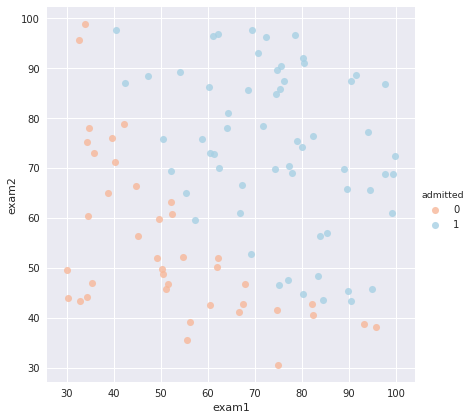

In [4]:
sns.set(context="notebook", style="darkgrid", palette=sns.color_palette("RdBu", 2))

sns.lmplot('exam1', 'exam2', hue='admitted', data=data, 
           size=6, 
           fit_reg=False, 
           scatter_kws={"s": 50}
          )
plt.show()#看下数据的样子

In [5]:
def get_X(df):#读取特征
#     """
#     use concat to add intersect feature to avoid side effect
#     not efficient for big dataset though
#     """
    ones = pd.DataFrame({'ones': np.ones(len(df))})#ones是m行1列的dataframe
    data = pd.concat([ones, df], axis=1)  # 合并数据，根据列合并
    return data.iloc[:, :-1].as_matrix()  # 这个操作返回 ndarray,不是矩阵


def get_y(df):#读取标签
#     '''assume the last column is the target'''
    return np.array(df.iloc[:, -1])#df.iloc[:, -1]是指df的最后一列


def normalize_feature(df):
#     """Applies function along input axis(default 0) of DataFrame."""
    return df.apply(lambda column: (column - column.mean()) / column.std())#特征缩放

In [6]:
X = get_X(data)
print(X.shape)

y = get_y(data)
print(y.shape)

(100, 3)
(100,)


# sigmoid 函数
g 代表一个常用的逻辑函数（logistic function）为S形函数（Sigmoid function），公式为： \\[g\left( z \right)=\frac{1}{1+{{e}^{-z}}}\\] 
合起来，我们得到逻辑回归模型的假设函数： 
	\\[{{h}_{\theta }}\left( x \right)=\frac{1}{1+{{e}^{-{{\theta }^{T}}X}}}\\] 


In [7]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

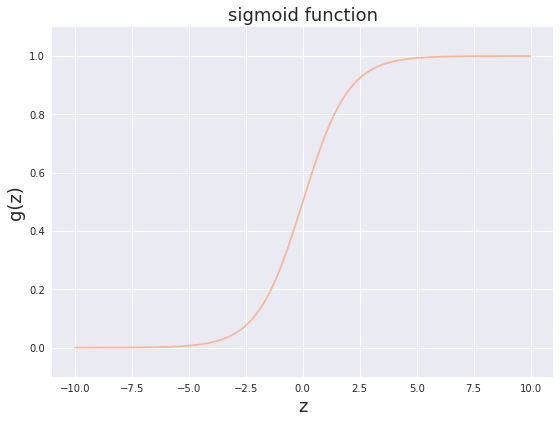

In [8]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(np.arange(-10, 10, step=0.01),
        sigmoid(np.arange(-10, 10, step=0.01)))
ax.set_ylim((-0.1,1.1))
ax.set_xlabel('z', fontsize=18)
ax.set_ylabel('g(z)', fontsize=18)
ax.set_title('sigmoid function', fontsize=18)
plt.show()

# cost function(代价函数)
> * $max(\ell(\theta)) = min(-\ell(\theta))$  
> * choose $-\ell(\theta)$ as the cost function

$$\begin{align}
  & J\left( \theta  \right)=-\frac{1}{m}\sum\limits_{i=1}^{m}{[{{y}^{(i)}}\log \left( {{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)+\left( 1-{{y}^{(i)}} \right)\log \left( 1-{{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)]} \\ 
 & =\frac{1}{m}\sum\limits_{i=1}^{m}{[-{{y}^{(i)}}\log \left( {{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)-\left( 1-{{y}^{(i)}} \right)\log \left( 1-{{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)]} \\ 
\end{align}$$


In [9]:
theta = theta=np.zeros(3) # X(m*n) so theta is n*1
theta

array([ 0.,  0.,  0.])

In [10]:
def cost(theta, X, y):
    ''' cost fn is -l(theta) for you to minimize'''
    return np.mean(-y * np.log(sigmoid(X @ theta)) - (1 - y) * np.log(1 - sigmoid(X @ theta)))

# X @ theta与X.dot(theta)等价

In [11]:
cost(theta, X, y)

0.69314718055994529

# gradient descent(梯度下降)
* 这是批量梯度下降（batch gradient descent）  
* 转化为向量化计算： $\frac{1}{m} X^T( Sigmoid(X\theta) - y )$
$$\frac{\partial J\left( \theta  \right)}{\partial {{\theta }_{j}}}=\frac{1}{m}\sum\limits_{i=1}^{m}{({{h}_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}})x_{_{j}}^{(i)}}$$

In [12]:
def gradient(theta, X, y):
#     '''just 1 batch gradient'''
    return (1 / len(X)) * X.T @ (sigmoid(X @ theta) - y)

In [13]:
gradient(theta, X, y)

array([ -0.1       , -12.00921659, -11.26284221])

# 拟合参数
> * 这里我使用 [`scipy.optimize.minimize`](http://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize) 去寻找参数  


In [14]:
import scipy.optimize as opt
res = opt.minimize(fun=cost, x0=theta, args=(X, y), method='Newton-CG', jac=gradient)
res

     fun: 0.20349770280321056
     jac: array([  1.31110614e-05,   8.53917373e-04,   6.71174423e-04])
 message: 'Optimization terminated successfully.'
    nfev: 73
    nhev: 0
     nit: 29
    njev: 253
  status: 0
 success: True
       x: array([-25.15847675,   0.20620886,   0.20144849])

In [15]:
# 用训练集预测和验证
def predict(x, theta):
    prob = sigmoid(x @ theta)
    return (prob >= 0.5).astype(int)

In [19]:
final_theta = res.x
y_pred = predict(X, final_theta)

print(classification_report(y, y_pred))

             precision    recall  f1-score   support

          0       0.87      0.85      0.86        40
          1       0.90      0.92      0.91        60

avg / total       0.89      0.89      0.89       100



# 寻找决策边界
http://stats.stackexchange.com/questions/93569/why-is-logistic-regression-a-linear-classifier
> $X \times \theta = 0$  (this is the line)

In [20]:
print(res.x) # this is final theta

[-25.15847675   0.20620886   0.20144849]


In [21]:
coef = -(res.x / res.x[2])  # find the equation
print(coef)

x = np.arange(130, step=0.1)
y = coef[0] + coef[1]*x

[ 124.88789225   -1.02363073   -1.        ]


In [22]:
data.describe()  # find the range of x and y

,exam1,exam2,admitted
count,100.000000,100.000000,100.000000
mean,65.644274,66.221998,0.600000
std,19.458222,18.582783,0.492366
min,30.058822,30.603263,0.000000
25%,50.919511,48.179205,0.000000
50%,67.032988,67.682381,1.000000
75%,80.212529,79.360605,1.000000
max,99.827858,98.869436,1.000000


> you know the intercept would be around 125 for both x and y

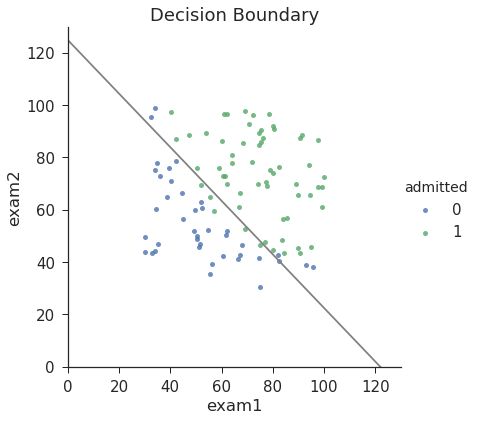

In [23]:
sns.set(context="notebook", style="ticks", font_scale=1.5)

sns.lmplot('exam1', 'exam2', hue='admitted', data=data, 
           size=6, 
           fit_reg=False, 
           scatter_kws={"s": 25}
          )

plt.plot(x, y, 'grey')
plt.xlim(0, 130)
plt.ylim(0, 130)
plt.title('Decision Boundary')
plt.show()

# 3- 正则化逻辑回归

In [25]:
df = pd.read_csv('ex2data2.txt', names=['test1', 'test2', 'accepted'])
df.head()

,test1,test2,accepted
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


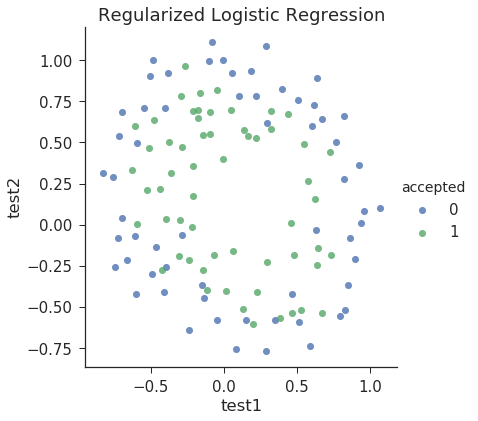

In [26]:
sns.set(context="notebook", style="ticks", font_scale=1.5)

sns.lmplot('test1', 'test2', hue='accepted', data=df, 
           size=6, 
           fit_reg=False, 
           scatter_kws={"s": 50}
          )

plt.title('Regularized Logistic Regression')
plt.show()

# feature mapping（特征映射）

polynomial expansion

```
for i in 0..i
  for p in 0..i:
    output x^(i-p) * y^p
```
<img style="float: left;" src="../img/mapped_feature.png">

In [28]:
def feature_mapping(x, y, power, as_ndarray=False):
#     """return mapped features as ndarray or dataframe"""
    # data = {}
    # # inclusive
    # for i in np.arange(power + 1):
    #     for p in np.arange(i + 1):
    #         data["f{}{}".format(i - p, p)] = np.power(x, i - p) * np.power(y, p)

    data = {"f{}{}".format(i - p, p): np.power(x, i - p) * np.power(y, p)
                for i in np.arange(power + 1)
                for p in np.arange(i + 1)
            }

    if as_ndarray:
        return pd.DataFrame(data).as_matrix()
    else:
        return pd.DataFrame(data)

In [29]:
x1 = np.array(df.test1)
x2 = np.array(df.test2)

In [34]:
data = feature_mapping(x1, x2, power=6)
print(data.shape)
data.head()

(118, 28)


,f00,f01,f02,f03,f04,f05,f06,f10,f11,f12,...,f30,f31,f32,f33,f40,f41,f42,f50,f51,f60
0,1.0,0.69956,0.489384,0.342354,0.239497,0.167542,0.117206,0.051267,0.035864,0.025089,...,0.000135,0.000094,0.000066,0.000046,0.000007,0.000005,0.000003,3.541519e-07,2.477505e-07,1.815630e-08
1,1.0,0.68494,0.469143,0.321335,0.220095,0.150752,0.103256,-0.092742,-0.063523,-0.043509,...,-0.000798,-0.000546,-0.000374,-0.000256,0.000074,0.000051,0.000035,-6.860919e-06,-4.699318e-06,6.362953e-07
2,1.0,0.69225,0.479210,0.331733,0.229642,0.158970,0.110047,-0.213710,-0.147941,-0.102412,...,-0.009761,-0.006757,-0.004677,-0.003238,0.002086,0.001444,0.001000,-4.457837e-04,-3.085938e-04,9.526844e-05
3,1.0,0.50219,0.252195,0.126650,0.063602,0.031940,0.016040,-0.375000,-0.188321,-0.094573,...,-0.052734,-0.026483,-0.013299,-0.006679,0.019775,0.009931,0.004987,-7.415771e-03,-3.724126e-03,2.780914e-03
4,1.0,0.46564,0.216821,0.100960,0.047011,0.021890,0.010193,-0.513250,-0.238990,-0.111283,...,-0.135203,-0.062956,-0.029315,-0.013650,0.069393,0.032312,0.015046,-3.561597e-02,-1.658422e-02,1.827990e-02


In [35]:
data.describe()

,f00,f01,f02,f03,f04,f05,f06,f10,f11,f12,...,f30,f31,f32,f33,f40,f41,f42,f50,f51,f60
count,118.0,118.000000,118.000000,118.000000,1.180000e+02,118.000000,1.180000e+02,118.000000,118.000000,118.000000,...,1.180000e+02,118.000000,1.180000e+02,118.000000,1.180000e+02,118.000000,1.180000e+02,1.180000e+02,118.000000,1.180000e+02
mean,1.0,0.183102,0.301370,0.142350,1.710985e-01,0.115710,1.257256e-01,0.054779,-0.025472,0.015483,...,5.983333e-02,-0.005251,9.432094e-03,-0.001705,1.225384e-01,0.011812,1.893340e-02,5.196507e-02,-0.000703,7.837118e-02
std,0.0,0.519743,0.284536,0.326134,2.815658e-01,0.299092,2.964416e-01,0.496654,0.224075,0.150143,...,2.746459e-01,0.096738,5.455787e-02,0.037443,2.092709e-01,0.072274,3.430092e-02,2.148098e-01,0.058271,1.938621e-01
min,1.0,-0.769740,0.000026,-0.456071,6.855856e-10,-0.270222,1.795116e-14,-0.830070,-0.484096,-0.483743,...,-5.719317e-01,-0.296854,-1.592528e-01,-0.113448,1.612020e-09,-0.246068,2.577297e-10,-3.940702e-01,-0.203971,6.472253e-14
25%,1.0,-0.254385,0.061086,-0.016492,3.741593e-03,-0.001072,2.298277e-04,-0.372120,-0.178209,-0.042980,...,-5.155632e-02,-0.029360,-3.659760e-03,-0.005749,1.869975e-03,-0.001926,1.258285e-04,-7.147973e-03,-0.006381,8.086369e-05
50%,1.0,0.213455,0.252195,0.009734,6.360222e-02,0.000444,1.604015e-02,-0.006336,-0.016521,-0.000039,...,-2.544062e-07,-0.000512,-1.473547e-07,-0.000005,2.736163e-02,0.000205,3.387050e-03,-1.021440e-11,-0.000004,4.527344e-03
75%,1.0,0.646562,0.464189,0.270310,2.155453e-01,0.113020,1.001215e-01,0.478970,0.100795,0.079510,...,1.099616e-01,0.015050,1.370560e-02,0.001024,1.520801e-01,0.019183,2.090875e-02,2.526861e-02,0.002104,5.932959e-02
max,1.0,1.108900,1.229659,1.363569,1.512062e+00,1.676725,1.859321e+00,1.070900,0.568307,0.505577,...,1.228137e+00,0.369805,2.451845e-01,0.183548,1.315212e+00,0.304409,2.018260e-01,1.408460e+00,0.250577,1.508320e+00


# regularized cost（正则化代价函数）
$$J\left( \theta  \right)=\frac{1}{m}\sum\limits_{i=1}^{m}{[-{{y}^{(i)}}\log \left( {{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)-\left( 1-{{y}^{(i)}} \right)\log \left( 1-{{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)]}+\frac{\lambda }{2m}\sum\limits_{j=1}^{n}{\theta _{j}^{2}}$$

In [36]:
theta = np.zeros(data.shape[1])
X = feature_mapping(x1, x2, power=6, as_ndarray=True)
print(X.shape)

y = get_y(df)
print(y.shape)

(118, 28)
(118,)


In [37]:
def regularized_cost(theta, X, y, l=1):
#     '''you don't penalize theta_0'''
    theta_j1_to_n = theta[1:]
    regularized_term = (l / (2 * len(X))) * np.power(theta_j1_to_n, 2).sum()

    return cost(theta, X, y) + regularized_term
#正则化代价函数

In [38]:
regularized_cost(theta, X, y, l=1)

0.6931471805599454

this is the same as the not regularized cost because we init theta as zeros... 因为我们设置theta为0，所以这个正则化代价函数与代价函数的值相同

# regularized gradient(正则化梯度)
$$\frac{\partial J\left( \theta  \right)}{\partial {{\theta }_{j}}}=\left( \frac{1}{m}\sum\limits_{i=1}^{m}{\left( {{h}_{\theta }}\left( {{x}^{\left( i \right)}} \right)-{{y}^{\left( i \right)}} \right)} \right)+\frac{\lambda }{m}{{\theta }_{j}}\text{ }\text{             for  j}\ge \text{1}$$

In [39]:
def regularized_gradient(theta, X, y, l=1):
#     '''still, leave theta_0 alone'''
    theta_j1_to_n = theta[1:]
    regularized_theta = (l / len(X)) * theta_j1_to_n

    # by doing this, no offset is on theta_0
    regularized_term = np.concatenate([np.array([0]), regularized_theta])

    return gradient(theta, X, y) + regularized_term

In [40]:
regularized_gradient(theta, X, y)

array([  8.47457627e-03,   7.77711864e-05,   3.76648474e-02,
         2.34764889e-02,   3.93028171e-02,   3.10079849e-02,
         3.87936363e-02,   1.87880932e-02,   1.15013308e-02,
         8.19244468e-03,   3.09593720e-03,   4.47629067e-03,
         1.37646175e-03,   5.03446395e-02,   7.32393391e-03,
         1.28600503e-02,   5.83822078e-03,   7.26504316e-03,
         1.83559872e-02,   2.23923907e-03,   3.38643902e-03,
         4.08503006e-04,   3.93486234e-02,   4.32983232e-03,
         6.31570797e-03,   1.99707467e-02,   1.09740238e-03,
         3.10312442e-02])

# 拟合参数

In [41]:
import scipy.optimize as opt
print('init cost = {}'.format(regularized_cost(theta, X, y)))

res = opt.minimize(fun=regularized_cost, x0=theta, args=(X, y), method='Newton-CG', jac=regularized_gradient)
res

init cost = 0.6931471805599454


     fun: 0.5290027297128032
     jac: array([  1.21715281e-07,   8.28608238e-08,   4.33264464e-08,
         7.14607751e-09,  -1.95796824e-08,  -4.80293320e-09,
         1.29548304e-08,  -8.66022925e-09,  -1.11692835e-08,
         2.44548549e-09,   5.97159799e-09,  -3.10175481e-09,
         2.84088139e-09,   3.68493808e-08,   2.44239121e-09,
         1.38623362e-09,   1.30580781e-09,  -2.07975693e-10,
        -2.03184463e-09,  -4.75280011e-09,   3.06506937e-10,
         6.83218269e-10,   2.06530132e-08,   2.83727034e-10,
         3.70483493e-09,   3.98612695e-09,  -2.46467884e-09,
         7.81200474e-09])
 message: 'Optimization terminated successfully.'
    nfev: 7
    nhev: 0
     nit: 6
    njev: 66
  status: 0
 success: True
       x: array([ 1.2727394 ,  1.18109077, -1.43166316, -0.17513213, -1.19281993,
       -0.45635881, -0.92465134,  0.62527173, -0.91742446, -0.35723923,
       -0.27470558, -0.29537848, -0.14388666, -2.01996079, -0.36553541,
       -0.61555568, -0.27778476, -

# 预测

In [42]:
final_theta = res.x
y_pred = predict(X, final_theta)

print(classification_report(y, y_pred))

             precision    recall  f1-score   support

          0       0.90      0.75      0.82        60
          1       0.78      0.91      0.84        58

avg / total       0.84      0.83      0.83       118



# 使用不同的 $\lambda$ （这个是常数）
# 画出决策边界
* 我们找到所有满足 $X\times \theta = 0$ 的x
* instead of solving polynomial equation, just create a coridate x,y grid that is dense enough, and find all those $X\times \theta$ that is close enough to 0, then plot them

In [43]:
def draw_boundary(power, l):
#     """
#     power: polynomial power for mapped feature
#     l: lambda constant
#     """
    density = 1000
    threshhold = 2 * 10**-3

    final_theta = feature_mapped_logistic_regression(power, l)
    x, y = find_decision_boundary(density, power, final_theta, threshhold)

    df = pd.read_csv('ex2data2.txt', names=['test1', 'test2', 'accepted'])
    sns.lmplot('test1', 'test2', hue='accepted', data=df, size=6, fit_reg=False, scatter_kws={"s": 100})

    plt.scatter(x, y, c='R', s=10)
    plt.title('Decision boundary')
    plt.show()

In [44]:
def feature_mapped_logistic_regression(power, l):
#     """for drawing purpose only.. not a well generealize logistic regression
#     power: int
#         raise x1, x2 to polynomial power
#     l: int
#         lambda constant for regularization term
#     """
    df = pd.read_csv('ex2data2.txt', names=['test1', 'test2', 'accepted'])
    x1 = np.array(df.test1)
    x2 = np.array(df.test2)
    y = get_y(df)

    X = feature_mapping(x1, x2, power, as_ndarray=True)
    theta = np.zeros(X.shape[1])

    res = opt.minimize(fun=regularized_cost,
                       x0=theta,
                       args=(X, y, l),
                       method='TNC',
                       jac=regularized_gradient)
    final_theta = res.x

    return final_theta

In [45]:
def find_decision_boundary(density, power, theta, threshhold):
    t1 = np.linspace(-1, 1.5, density)
    t2 = np.linspace(-1, 1.5, density)

    cordinates = [(x, y) for x in t1 for y in t2]
    x_cord, y_cord = zip(*cordinates)
    mapped_cord = feature_mapping(x_cord, y_cord, power)  # this is a dataframe

    inner_product = mapped_cord.as_matrix() @ theta

    decision = mapped_cord[np.abs(inner_product) < threshhold]

    return decision.f10, decision.f01
#寻找决策边界函数

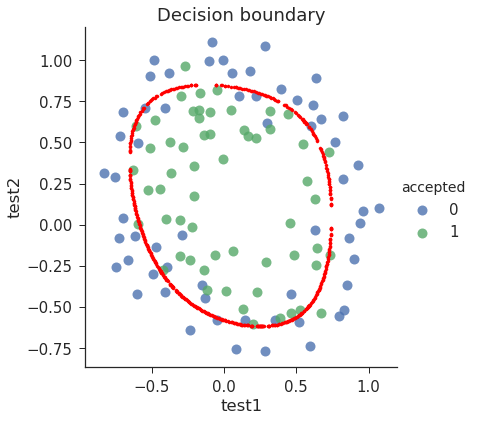

In [46]:
draw_boundary(power=6, l=1)#lambda=1

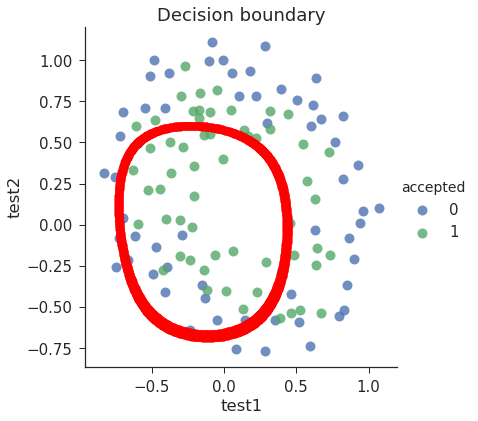

In [47]:
draw_boundary(power=6, l=100)  # underfitting，#lambda=100,欠拟合